In [160]:
import os
import numpy as np
from plot_params import *
from scipy.spatial.distance import cdist
from copy import deepcopy
from tqdm import tqdm
from joblib import Parallel, delayed
from matplotlib.animation import FuncAnimation
import math


In [161]:
"""
TODO: 
- Different cooling schedules
- Decrease stepsize

Figures:
- Examples using both cooling schemes with n = 12, 30, 56
- 
"""

'\nTODO: \n- Different cooling schedules\n- Decrease stepsize\n\nFigures:\n- Examples using both cooling schemes with n = 12, 30, 56\n- \n'

In [217]:
def total_energy(pos):
    dist = cdist(pos, pos)
    li = np.tril_indices(len(pos), k=-1)
    pair_dist = dist[li]
    total_energy = (1 / pair_dist).sum()
    return total_energy


def accept_move(T, alpha_log, j, energy_after, energy_before):
    delta_energy = energy_after - energy_before
    if delta_energy < 0:
        return True
    alpha = np.exp(- delta_energy / T[j]) 
    alpha_log[j] = alpha
    if np.random.rand() <= alpha:
        return True
    return False


def random_move(pos, i):
    og = deepcopy(pos)
    move = np.random.uniform(-1, 1, 2)
    normal_move = move / np.linalg.norm(move)
    pos[i] = og[i] + normal_move * stepsize

    if np.sqrt(pos[i][0] ** 2 + pos[i][1] ** 2) < circle_radius:
        return pos
    return og


def run():
    # initialize particles
    r = np.random.rand(n) * 0.1
    theta = np.random.rand(n) * 2 * np.pi
    x = np.cos(theta) * r
    y = np.sin(theta) * r
    pos = np.stack((x, y), axis=1)
    alpha_log = np.zeros(steps)

    # loop temp
    for j in tqdm(range(steps)):
        pos_history[j] = pos

        # loop charge
        for i in range(n):
            energy_before = total_energy(pos)
            possible_pos = random_move_with_drift(deepcopy(pos), i, j)
            energy_after = total_energy(possible_pos)
            if accept_move(T, alpha_log, j, energy_after, energy_before):
                pos = possible_pos

    return pos
    

def random_move_with_drift(pos, i, j):
    og = deepcopy(pos)

    # calc force
    r = cdist(pos, pos)
    r = r[i]
    r = r[r != 0]

    r_x = pos[:, 0].reshape(-1 , 1) - pos[:, 0]
    r_x = r_x[i]
    r_x = r_x[r_x != 0]

    r_y = pos[:, 1].reshape(-1 , 1) - pos[:, 1]
    r_y = r_y[i]
    r_y = r_y[r_y != 0]

    force = np.stack((r_x / np.abs(r ** 3), r_y / np.abs(r ** 3)), axis=1)
    total_force = force.sum(axis=0)

    normal_force_move = total_force / np.linalg.norm(total_force)

    # calc random
    random_move = np.random.uniform(-1, 1, 2)
    normal_random_move = random_move / np.linalg.norm(random_move)

    # add together
    combined_step = normal_random_move * random_influence + normal_force_move * force_influence
    normal_step =  combined_step / np.linalg.norm(combined_step)
    step =  normal_step * stepsize[j]
    
    pos[i] = og[i] + step
    step_size = np.linalg.norm(step)

    # check if outside of circle
    if np.sqrt(pos[i][0] ** 2 + pos[i][1] ** 2) < circle_radius:
        return pos
    
    # if (pos > 1).any() or (pos < -1).any():
    #     return og
    # return pos

   
    
    
    # if not, move across the circle edge
    dist_to_circle = circle_radius-math.sqrt(pos[i, :][0]**2+pos[i, :][1]**2)
    step_angle = np.arctan2(step[1], step[0])
    
    point_angle = np.arctan2(pos[i, 1], pos[i, 0])
    
    angle_dif = step_angle-point_angle
    arc_length = step_size-dist_to_circle
    arc_angle = math.copysign(arc_length / circle_radius,angle_dif)
        
    pos[i, 0] = math.cos(point_angle+arc_angle)*circle_radius
    pos[i, 1] = math.sin(point_angle+arc_angle)*circle_radius

    return pos


def cooling_logistic(steps):
    B = 7
    vu = 5
    M = 5
    i = np.linspace(10, 1, steps)
    T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu)) 
    return T


def cooling_exponential(steps):
    T_init = 1
    constant = 0.965
    T = np.zeros(steps)
    for i in range(steps):
        T[i] = T_init*pow(constant,i)
    return T


In [194]:
# settings
steps = 150
stepsize_i = 0.05
stepsize_f = 0.02
stepsize = np.linspace(stepsize_i, stepsize_f, steps)
n = 12
runs = 100
best_runs = 10
random_influence = 1
force_influence = 1
circle_radius = 1
pos_history = np.zeros((steps, n, 2))

# temp function
T = cooling_logistic(steps)
T = cooling_exponential(steps)

# pich the best multiple times
all_best = np.zeros((best_runs, n, 2))
for i in tqdm(range(best_runs)):

    # run 
    results = Parallel(n_jobs=-1, verbose=0)(delayed(run)() for _ in range(runs))
    results = np.array(results)

    # pick the best and worst
    quality = []
    for r in results:
        q = total_energy(r)
        quality.append(q)
    best = results[np.argmin(quality)]
    worst = results[np.argmax(quality)]
    all_best[i] = best

# save
np.save(f'best.npy', all_best)

100%|██████████| 10/10 [01:21<00:00,  8.20s/it]


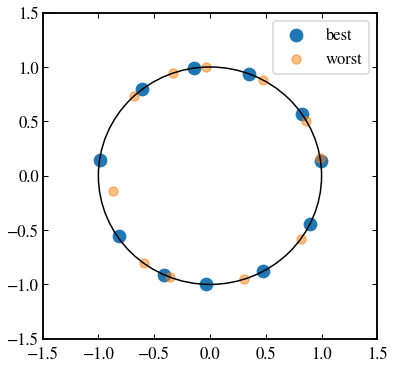

In [164]:
# plot best and worst outcome
plt.figure(figsize=(6, 6))
plt.scatter(best[:, 0], best[:, 1], label='best', s=150)
plt.scatter(worst[:, 0], worst[:, 1], label='worst', alpha=0.5)
plt.legend()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
circle = plt.Circle((0, 0), 1, fill=False)
plt.gca().add_patch(circle)
plt.show()

In [173]:
# # settings
# steps = 200

# stepsize_i = 0.05
# stepsize_f = 0.01
# stepsize = np.linspace(stepsize_i, stepsize_f, steps)
# n = 11
# runs = 100

# best_runs = 10
# random_influence = 0.7
# force_influence = 0.3
# circle_radius = 1
# pos_history = np.zeros((steps, n, 2))

# # temp function
# i = np.linspace(10, 1, steps)
# B = 7
# vu = 5
# M = 5
# T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu)) #- 0.3# logistic because cool

# magic_count = 0
# N = 100
# pos = run()
# for _ in range(N):
#     pos = run()
#     if (np.sqrt(pos[:, 0] ** 2 + pos[:, 1] ** 2) < 0.1).any():
#         magic_count += 1
#     # plt.figure(figsize=(6, 6))
#     # plt.scatter(pos[:, 0], pos[:, 1], label='best', s=150)
#     # plt.legend()
#     # plt.xlim(-1.5, 1.5)
#     # plt.ylim(-1.5, 1.5)
#     # circle = plt.Circle((0, 0), 1, fill=False)
#     # plt.gca().add_patch(circle)
#     # plt.show()
# magic_count, N

100%|██████████| 200/200 [00:00<00:00, 430.31it/s]


(23, 100)

100%|██████████| 100/100 [00:01<00:00, 56.66it/s]


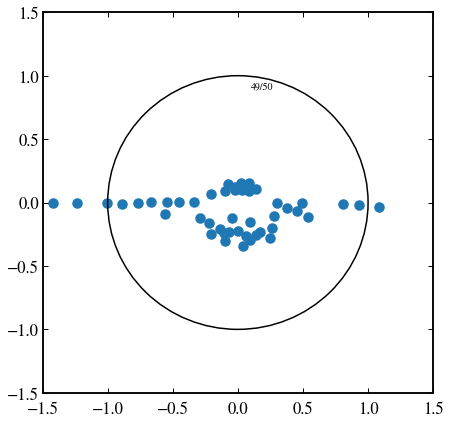

In [218]:
# settings
steps = 100

stepsize_i = 0.05
stepsize_f = 0.01
stepsize = np.linspace(stepsize_i, stepsize_f, steps)
n = 50
runs = 100

best_runs = 10
random_influence = 1
force_influence = 1
circle_radius = 1
pos_history = np.zeros((steps, n, 2))

# temp function
i = np.linspace(10, 1, steps)
B = 7
vu = 5
M = 5
T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu)) #- 0.3# logistic because cool 

pos = run()
frames = 50
sec = 5
pos_animate = pos_history[::steps//frames]
fig, ax = plt.subplots(figsize=(7, 7))
plot = ax.scatter(pos_animate[0, :, 0], pos_animate[0, :, 1])
text = ax.text(0.1, 0.9, '', fontsize=10)
circle = plt.Circle((0, 0), 1, fill=False)
plt.gca().add_patch(circle)
ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

def anim_func(i):
    plot.set_offsets(pos_animate[i])
    text.set_text(f'{i}/{frames}')
    return plot

animation = FuncAnimation(fig, anim_func, frames=frames, interval=sec / frames * 1e3, save_count=frames)
animation.save(f'kaas.mp4', dpi=100)

In [ ]:
# # temp function
# i = np.linspace(10, 1, steps)
# B = 7
# vu = 5
# M = 5
# T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu)) - 0.3# logistic because cool 

In [ ]:
# # temp function
# i = np.linspace(10, 1, steps)
# B = 7
# vu = 5
# M = 5
# T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu)) # logistic because cool 

# delta_energy = 

# p = lambda T: np.exp(- delta_energy / T)

# plt.plot(T, p(T))
# plt.ylim(0, 1)